In [45]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import numpy as np
import matplotlib.pylab as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import math
import itertools
import statsmodels.api as sm

In [3]:
data = pd.read_csv('ny.csv')

In [10]:
data.head()

,nybirths
0,26.663
1,23.598
2,26.931
3,24.740
4,25.806


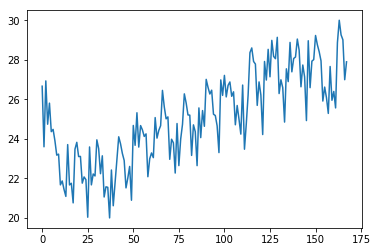

In [12]:
ts = data['nybirths']
plt.plot(ts)

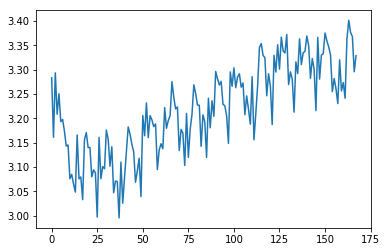

In [16]:
ts_log = np.log(ts)
plt.plot(ts_log)

In [5]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
    'p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

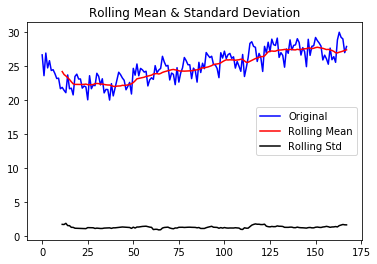

Results of Dickey-Fuller Test:
Test Statistic                  -0.331281
p-value                          0.920956
#Lags Used                      13.000000
Number of Observations Used    154.000000
Critical Value (1%)             -3.473543
Critical Value (5%)             -2.880498
Critical Value (10%)            -2.576878
dtype: float64


In [13]:
test_stationarity(ts)

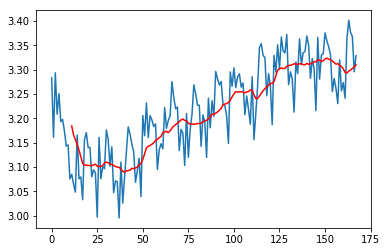

In [23]:
"""Detrending"""

moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

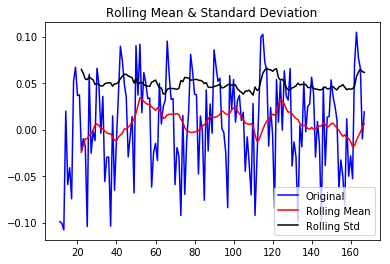

Results of Dickey-Fuller Test:
Test Statistic                  -2.926716
p-value                          0.042328
#Lags Used                      13.000000
Number of Observations Used    143.000000
Critical Value (1%)             -3.476927
Critical Value (5%)             -2.881973
Critical Value (10%)            -2.577665
dtype: float64


In [24]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

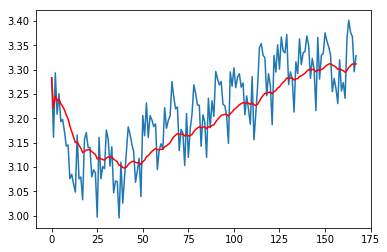

In [25]:
"""Exponentially weighted moving average"""

expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

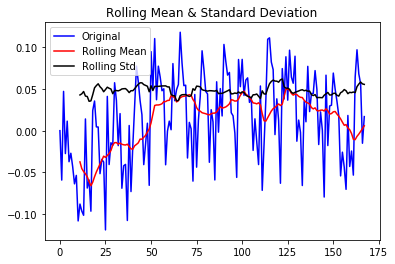

Results of Dickey-Fuller Test:
Test Statistic                  -2.444335
p-value                          0.129612
#Lags Used                      13.000000
Number of Observations Used    154.000000
Critical Value (1%)             -3.473543
Critical Value (5%)             -2.880498
Critical Value (10%)            -2.576878
dtype: float64


In [26]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

FORECASTING

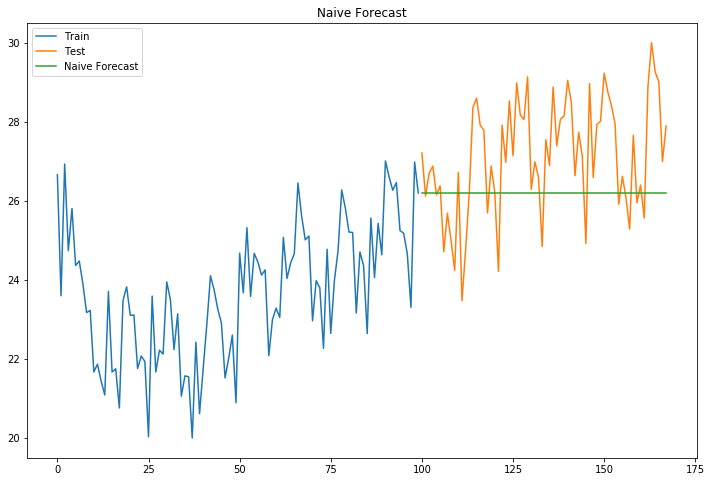

In [29]:
"""Naive forecasting"""
train=ts[0:100]
test=ts[100:]

val = train[len(train)-1]
y_hat = pd.Series(np.full(shape=len(test),fill_value=val),test.index)
plt.figure(figsize=(12,8))
plt.plot(train.index, train, label='Train')
plt.plot(test.index,test, label='Test')
plt.plot(y_hat.index, y_hat, label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

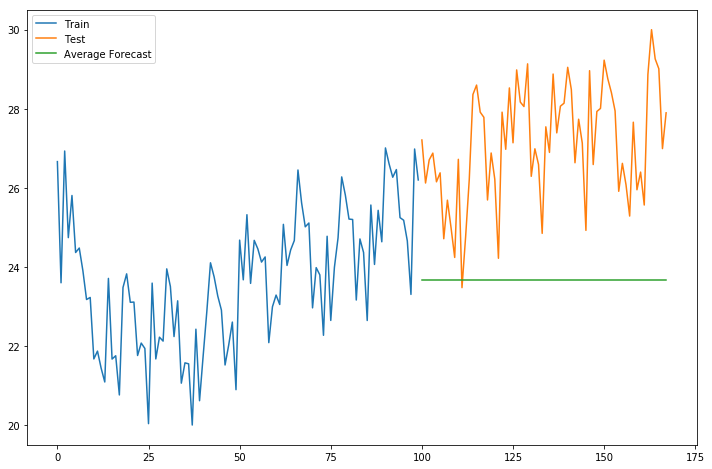

In [30]:
# SIMPLE AVERAGE
val = train.mean()
y_hat_avg = pd.Series(np.full(shape=len(test),fill_value=val),test.index)
plt.figure(figsize=(12,8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_hat_avg, label='Average Forecast')
plt.legend(loc='best')
plt.show()

In [33]:
rms = math.sqrt(mean_squared_error(test, y_hat_avg))
print(rms)

3.7366523566107506


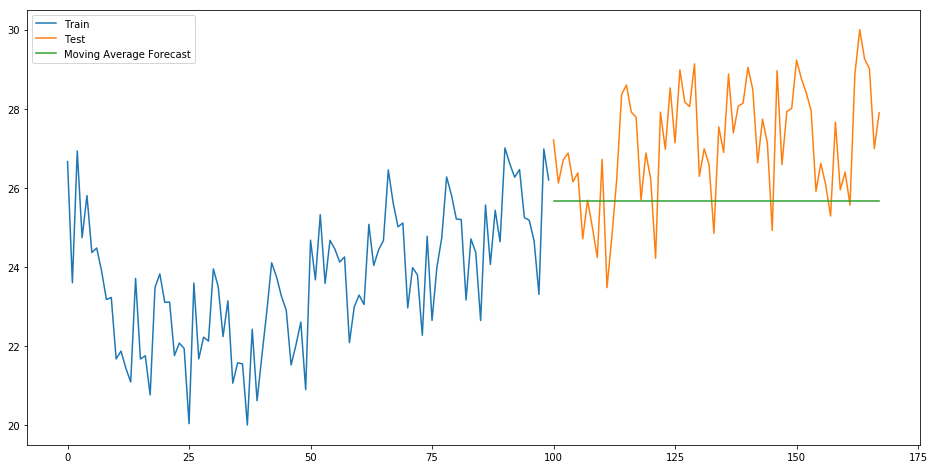

In [34]:
#Moving Average
val = train.rolling(12).mean().iloc[-1]
y_hat_avg = pd.Series(np.full(shape=len(test),fill_value=val),test.index)
plt.figure(figsize=(16,8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_hat_avg, label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [35]:
rms = math.sqrt(mean_squared_error(test, y_hat_avg))
print(rms)

2.0370312998941342


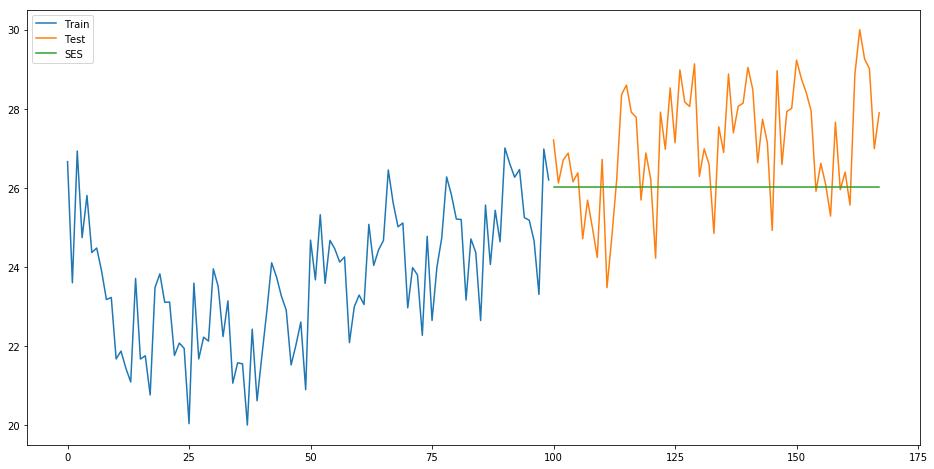

In [36]:
#Simple exp smoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
fit2 = SimpleExpSmoothing(np.asarray(train)).fit(smoothing_level=0.6,optimized=False)
series = fit2.forecast(len(test))
y_hat_ses = pd.Series(series, test.index)
plt.figure(figsize=(16,8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_hat_ses, label='SES')
plt.legend(loc='best')
plt.show()

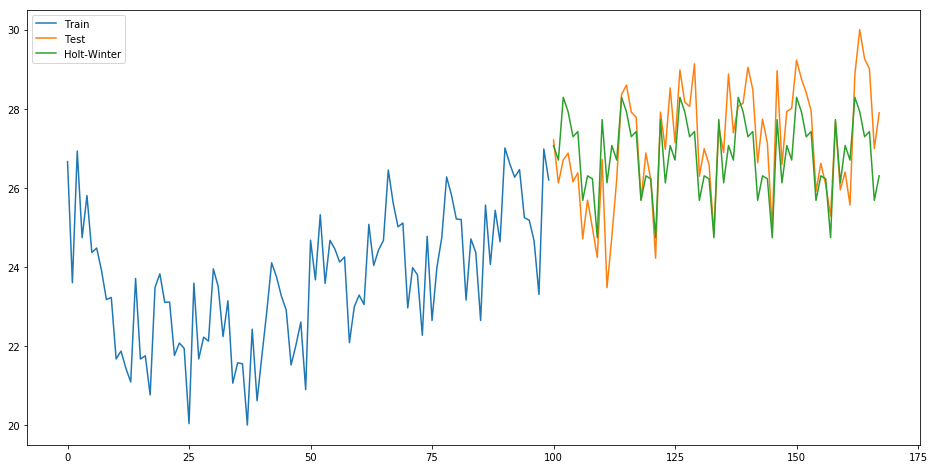

In [38]:
#Holt-Winter seasonal method
fithw = ExponentialSmoothing(np.asarray(train),
seasonal_periods=12, trend='add', seasonal='add').fit()
series = fithw.forecast(len(test))
y_hat_hw = pd.Series(series, test.index)
plt.figure(figsize=(16,8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_hat_hw, label='Holt-Winter')
plt.legend(loc='best')
plt.show()

In [39]:
rms = math.sqrt(mean_squared_error(test, y_hat_hw))
print(rms)

1.014705003091817


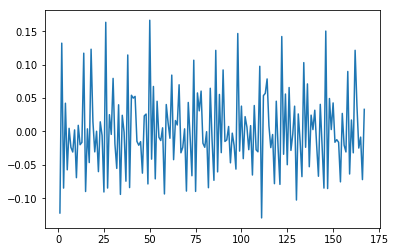

In [53]:
#Differencing
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

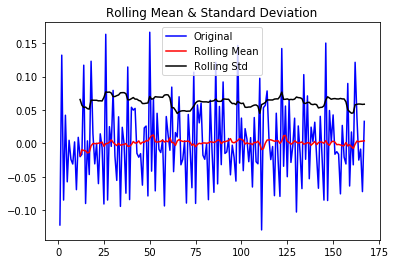

Results of Dickey-Fuller Test:
Test Statistic                  -4.528129
p-value                          0.000175
#Lags Used                      14.000000
Number of Observations Used    152.000000
Critical Value (1%)             -3.474121
Critical Value (5%)             -2.880750
Critical Value (10%)            -2.577013
dtype: float64


In [54]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

Text(0.5, 1.0, 'Autocorrelation Function')

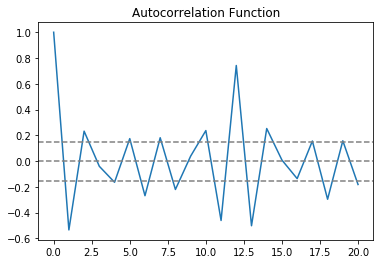

In [55]:
#ARIMA PREP
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=20)
#Plot ACF:
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

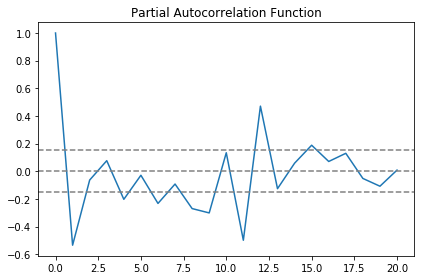

In [56]:
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')
#Plot PACF:
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

/usr/local/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/usr/local/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/usr/local/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

Text(0.5, 1.0, 'RSS: 0.4424')

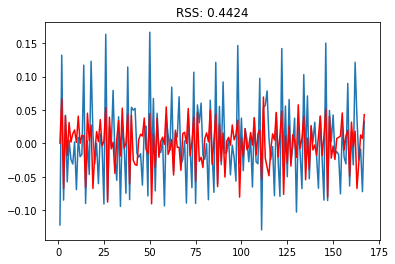

In [57]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log, order=(2, 1, 0))
results_AR = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

Text(0.5, 1.0, 'RSS: 0.4510')

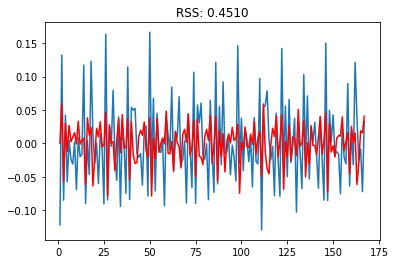

In [58]:
model = ARIMA(ts_log, order=(0, 1, 2))
results_MA = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

In [49]:
#ARIMA

import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [46]:
fit0 = sm.tsa.statespace.SARIMAX(train, order=(0, 0, 1), seasonal_order=(0,1,1,12)).fit()
print(fit0.aic)
fit1 = sm.tsa.statespace.SARIMAX(train, order=(1, 0, 1), seasonal_order=(0,1,1,12)).fit()
print(fit1.aic)
fit2 = sm.tsa.statespace.SARIMAX(train, order=(1, 0, 2), seasonal_order=(0,1,1,12)).fit()
print(fit2.aic)

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


265.89305285694263
192.11285987247322
193.58884668128343


In [59]:
print(fit2.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9889      0.074     13.420      0.000       0.844       1.133
ma.L1         -0.1129      0.102     -1.110      0.267      -0.312       0.087
ma.L2         -0.0768      0.132     -0.581      0.561      -0.336       0.182
ma.S.L12      -0.9918      4.903     -0.202      0.840     -10.601       8.617
sigma2         0.3553      1.717      0.207      0.836      -3.010       3.721


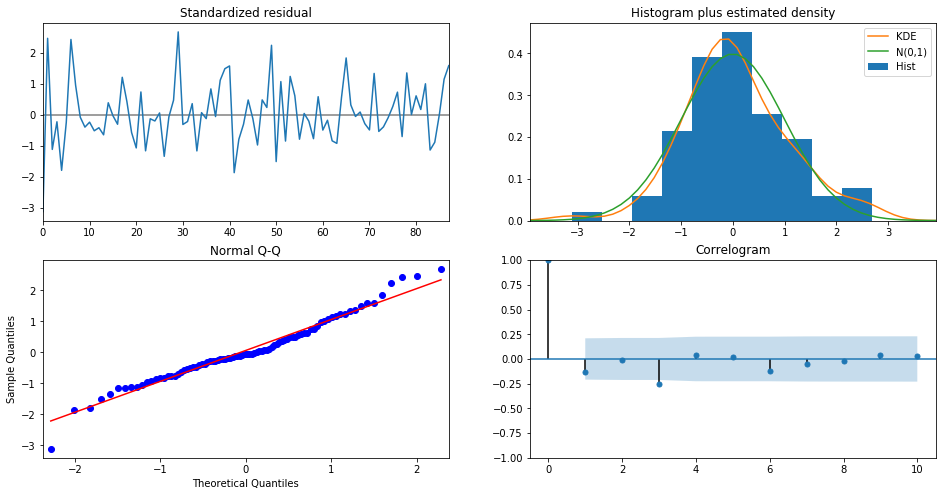

In [60]:
fit2.plot_diagnostics(figsize=(16, 8))
plt.show()